In [1]:
!ulimit -n 4096

In [2]:
import kagglehub

path = kagglehub.dataset_download("splcher/animefacedataset")
print("Path to dataset files:", path)

Path to dataset files: /Users/llukii/.cache/kagglehub/datasets/splcher/animefacedataset/versions/3


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torchvision.utils import make_grid
from torch.utils.data import DataLoader, Dataset

import os
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm

from warnings import filterwarnings
filterwarnings("ignore")

In [4]:
dataset_path = "/Users/llukii/.cache/kagglehub/datasets/splcher/animefacedataset/versions/3/images"
image_data = []
for image_path in os.listdir(dataset_path)[:10000]:
    image = Image.open("{}/{}".format(dataset_path, image_path))
    image_data.append(image)

In [5]:
device = torch.device("mps" if torch.mps.is_available() else "cpu")
batch_size = 32
lr = 0.0002
ngf = ndf = 64
num_epochs = 10
nz = 1000
num_channels = 3

In [6]:
print(len(image_data))

10000


In [7]:
transform = transforms.Compose([
    transforms.Resize((ngf, ngf)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

class AnimeDataset(Dataset):
    def __init__(self, data, transform):
        self.transform = transform
        self.data = data

    def __len__(self): return len(self.data)
    def __getitem__(self, idx):
        return self.transform(self.data[idx])

dataloader = DataLoader(AnimeDataset(image_data, transform), batch_size=32, shuffle=True)

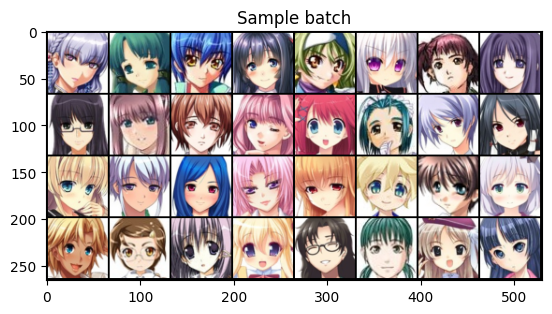

In [8]:
test_batch = next(iter(dataloader))
grid = make_grid(test_batch, nrow=8, normalize=True)
plt.title("Sample batch")
plt.imshow(grid.permute(1, 2, 0))

In [9]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.network = nn.Sequential(
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(ngf, num_channels, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        return self.network(x)

In [10]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.network = nn.Sequential(
            nn.Conv2d(num_channels, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.network(x)

In [11]:
loss = nn.BCELoss()
generator = Generator().to(device)
discriminator = Discriminator().to(device)

optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

In [12]:
d_loss_list = []
g_loss_list = []
def train_model():
    d_loss, gen_loss = 0, 0
    for i, data in enumerate(dataloader):
        # train discriminator
        labels = torch.ones(len(data)).to(device)
        data = data.to(device)
        real_pred = discriminator(data).view(-1)
        real_loss = loss(real_pred, labels)
        optimizer_D.zero_grad()

        labels = torch.zeros(len(data)).to(device)
        noise = torch.randn(len(data), nz, 1, 1, device=device)
        generated_images = generator(noise)
        fake_pred = discriminator(generated_images.detach()).view(-1)
        fake_loss = loss(fake_pred, labels)

        total_loss = real_loss + fake_loss
        total_loss.backward()
        optimizer_D.step()
        d_loss = total_loss.item()

        # train generator
        labels = torch.ones(len(data)).to(device)
        optimizer_G.zero_grad()
        fake_pred = discriminator(generated_images).view(-1)
        gen_loss = loss(fake_pred, labels)
        gen_loss.backward()
        optimizer_G.step()
        gen_loss = gen_loss.item()

        d_loss_list.append(d_loss)
        g_loss_list.append(gen_loss)

        if i % 100 == 0:
            print(f"Step {i}: Discriminator loss: {d_loss}, Generator loss: {gen_loss}")

In [13]:
for epoch in range(num_epochs):
    print("Epoch {}".format(epoch + 1))
    train_model()

Epoch 1
step
step
step
step
Discriminator loss: 0.3404619097709656
Generator loss: 3.7595553398132324
Epoch 2
step
step
step
step
Discriminator loss: 1.13235604763031
Generator loss: 10.303821563720703
Epoch 3
step
step
step
step
Discriminator loss: 0.4525880515575409
Generator loss: 8.652063369750977
Epoch 4
step
step
step
step
Discriminator loss: 0.20400452613830566
Generator loss: 6.470282554626465
Epoch 5
step
step
step
step
Discriminator loss: 0.12340382486581802
Generator loss: 4.061898708343506
Epoch 6
step
step
step
step
Discriminator loss: 0.07606110721826553
Generator loss: 5.098719120025635
Epoch 7
step
step
step
step
Discriminator loss: 0.2657523453235626
Generator loss: 5.098643779754639
Epoch 8
step
step
step
step
Discriminator loss: 0.07408462464809418
Generator loss: 4.139119625091553
Epoch 9
step
step
step
step
Discriminator loss: 0.15202908217906952
Generator loss: 6.891162872314453
Epoch 10
step
step
step
step
Discriminator loss: 0.15717577934265137
Generator loss: 6

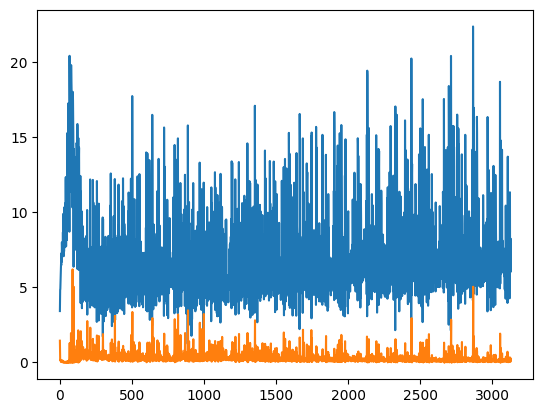

In [14]:
plt.plot(g_loss_list)
plt.plot(d_loss_list)

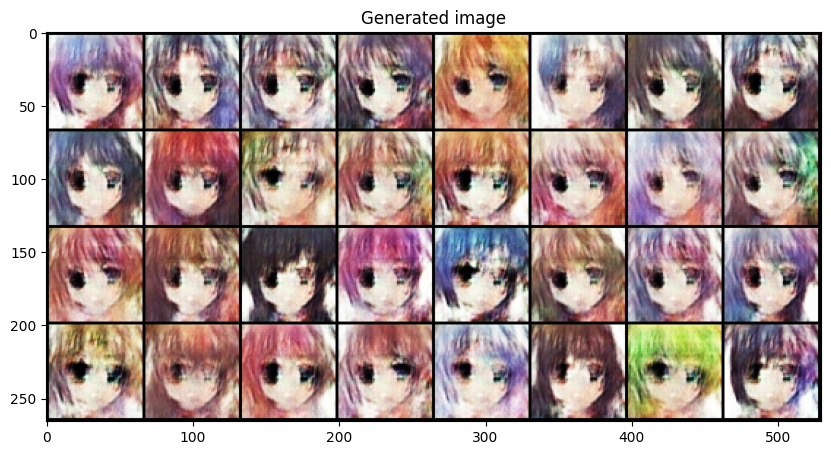

In [17]:
noise = torch.randn(32, nz, 1, 1, device=device)
generated_image = generator(noise)
grid = make_grid(generated_image.cpu(), nrow=8, normalize=True)
plt.figure(figsize=(10, 10))
plt.title("Generated image")
plt.imshow(grid.permute(1, 2, 0))